In [1]:
#   Case Porto Cred para score de credito
#   7 de julho de 2021
#
# Carga da planilha de dados da portocred
# 5000 registros/ 8 colunas
#
# Campos existentes na base de dados
#   idade - idade do cliente em anos
#   experiencia - tempo de experiência em anos
#   tempo_endereco - tempo que mora no mesmo endereço em anos
#   renda - renda anual em salários mínimos
#   debito_renda - relação entre seus débitos (dívidas totais) e a renda anual
#   cred_deb - razão entre seus créditos e débitos
#   outros_debitos - Valor de outros débitos (em 1.000 reais)
#   mau - se pagou o não o empréstimo bancário (0=pagou, 1=não pagou)
#
# Questôes Levantadas
#
# a) Faça uma exploração dos dados envolvidos nessa base, avaliar seus valores envolvidos
#
# b) Há algum outlier que mereça atenção? E com relação a dados faltantes, existem? 
#
# c) Qual o percentual de empréstimos não pagos (0 significa pago e 1 significa não pago ou "default" ou ainda "mau")?
#
# d) Qual a correlação entre as variáveis presentes na base de dados? Categorize as variáveis e explique o método de categorização e explique o algoritmo usado na análise de correlação entre variáveis categóricas
#
# e) Quais são as variáveis que melhor explicam se o empréstimo foi pago ou não? (Aplique o conceito de Information Value)
#
# f) Ajuste um modelo logístico e avalie quais variáveis apareceram como significantes e quais não. Discuta o p-valor da regressão e, se for necessário, crie uma nova regressão com coeficientes estatisticamente significantes. Explique o significado do p-valor.
#
# g) Calcule o score de propensão a default como uma coluna nova na base (Probabilidade de ser "default" ou P(mau=1))
#
# h) Qual a sugestão inicial de ponto de corte para predizer se o empréstimo será pago ou não?
#
# i) Considerando essa sugestão, desenhe a matriz de confusão e calcule a sensibilidade e especificidade.
#
# j) Use as métricas de KS e ROC / AUC para avaliar o poder de separação entre os grupos ("1" e "0").
#
# k) Avalie a discriminação por faixas de Score para a variável "default". Existe alguma inversão? Faça para 5 grupos (quintil) e 10 grupos (decil).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import pandas as pd
import seaborn as sns
from math import sqrt
import statsmodels.api as sm


In [3]:
# a) Faça uma exploração dos dados envolvidos nessa base, avaliar seus valores envolvidos
#

# a.1) carga de dados da planilha excel para dataframe (df)

df = pd.read_excel ('Documents//portocred-logit-base2.xlsx')

/Users/marcelo/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
# a.2) verificacao inicial de dimensoes e conteudo

print(df.shape)

# OBS> dataframe de 5000 registros e 8 colunas

df.head(5)

# OBS>
# variaveis independentes  (X): idade experiencia tempo_endereco renda debito_renda cred_deb outros_debitos
# variavel dependente (y) mau
# Todas numericas, sem cariaveis tipo texto ou categoricas.  variavel target (mau) binaria

(5000, 8)


idade  experiencia  tempo_endereco  renda  debito_renda  cred_deb  \
0     41           17              12   35.9         11.90  0.504108   
1     30           13               8   46.7         17.88  1.352694   
2     40           15              14   61.8         10.64  3.438997   
3     41           15              14   72.0         29.67  4.165668   
4     57            7              37   25.6         15.86  1.498199   

   outros_debitos  mau  
0        3.767992    0  
1        6.997266    0  
2        3.136523    0  
3       17.196732    0  
4        2.561961    0

In [5]:
# a.3) sumario com estatisticas da tabela

df.describe()

# OBS>  Valor maximo de renda muito distante da media, possivel outlier.  Inspecionar.


idade  experiencia  tempo_endereco        renda  debito_renda  \
count  5000.000000  5000.000000     5000.000000  5000.000000   5000.000000   
mean     35.387200     8.703800        8.154000    47.676980     10.075984   
std       7.948403     7.194583        6.760786    51.793192      6.659336   
min      20.000000     0.000000        0.000000    12.100000      0.080000   
25%      29.000000     3.000000        3.000000    24.500000      5.050000   
50%      35.000000     7.000000        7.000000    34.500000      8.635000   
75%      41.000000    13.000000       12.000000    54.725000     13.682500   
max      58.000000    38.000000       37.000000  2461.700000     44.620000   

          cred_deb  outros_debitos          mau  
count  5000.000000     5000.000000  5000.000000  
mean      1.628071        3.218582     0.251200  
std       3.053369        6.944523     0.433747  
min       0.005292        0.009373     0.000000  
25%       0.396181        0.990071     0.000000  
50%       0.906189        1.960223     0.000000  
75%       1.859147        3.789633     1.000000  
max     139.580606      416.517424     1.000000

In [6]:
# a.4) verificacao de existencia de registros NULL

df.isnull().sum()

# OBS> nao ha registros vazios

idade             0
experiencia       0
tempo_endereco    0
renda             0
debito_renda      0
cred_deb          0
outros_debitos    0
mau               0
dtype: int64

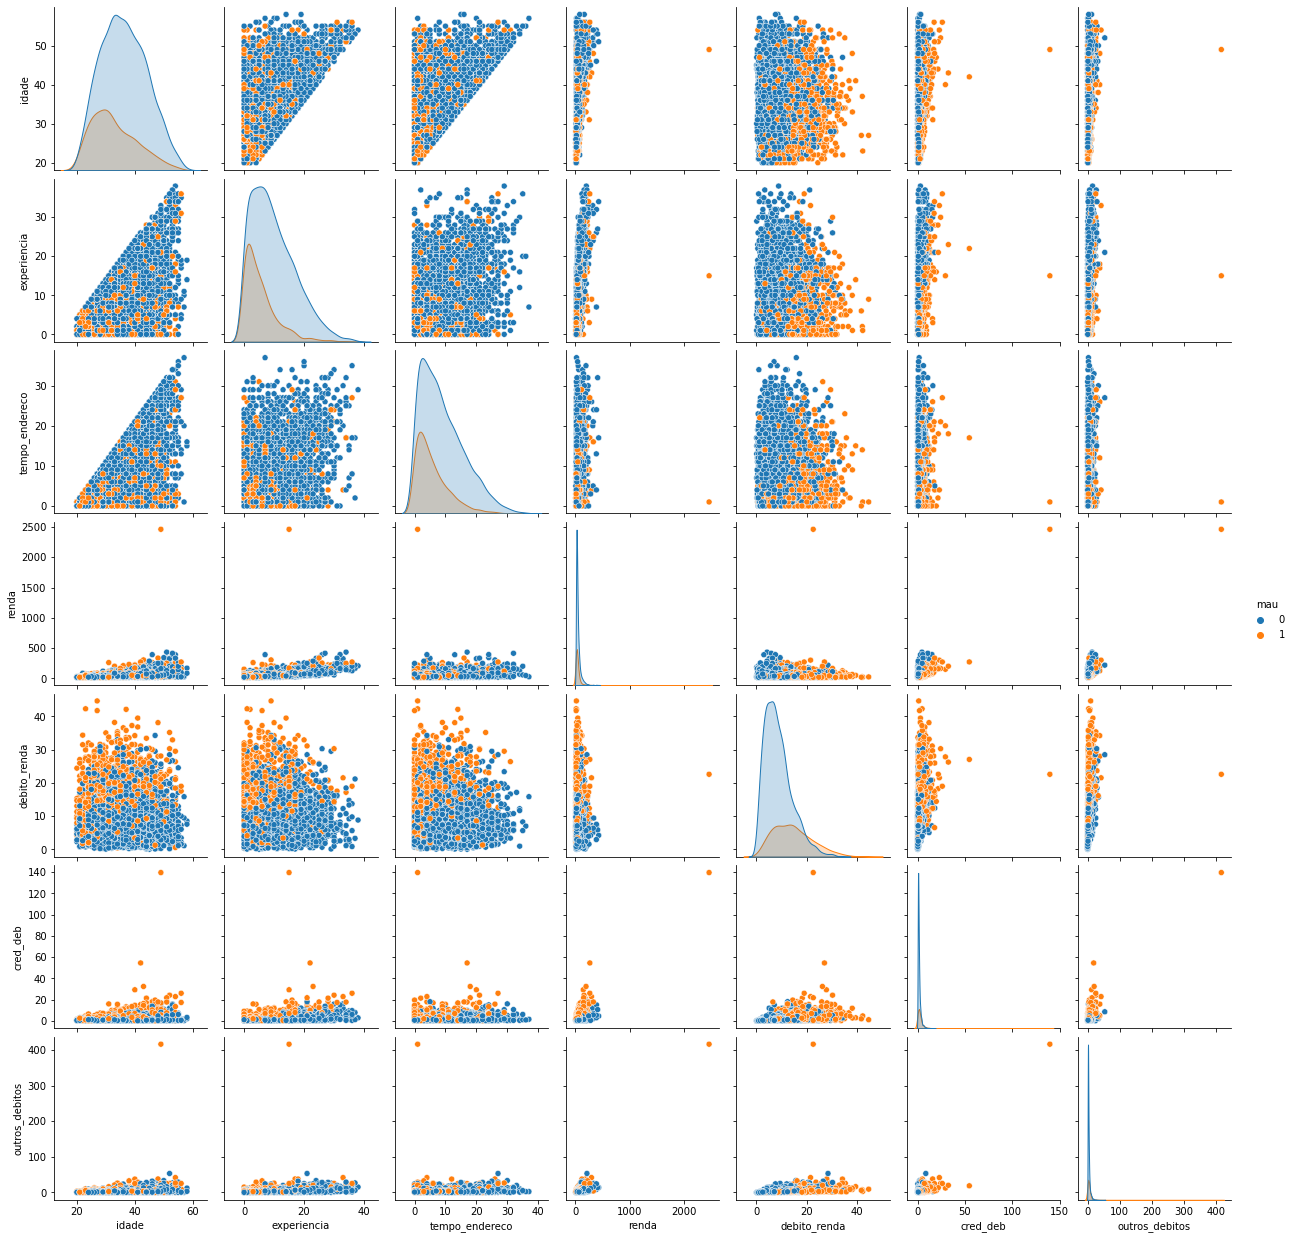

In [7]:
# b) Há algum outlier que mereça atenção? E com relação a dados faltantes, existem? 

# b.1) primeira visualizacao de scaterplot por pares para exploracao de padroes, correlacoes e outliers

pairs = sns.pairplot(df, hue="mau")

# OBS> distorcao de plots relacionados a renda reforcam existencia de outlier

In [8]:
# b.2) verificar outliers em renda

df[df['renda']>500]



idade  experiencia  tempo_endereco   renda  debito_renda    cred_deb  \
3563     49           15               1  2461.7         22.59  139.580606   

      outros_debitos  mau  
3563      416.517424    1

In [9]:
# b.3) remocao de outliers em renda, cred_deb e outros_debitos

df_clean01 = df[df['renda'] < 500]

# OBS> ha um outlier apenas Reg. Index 3563.  Excluido.

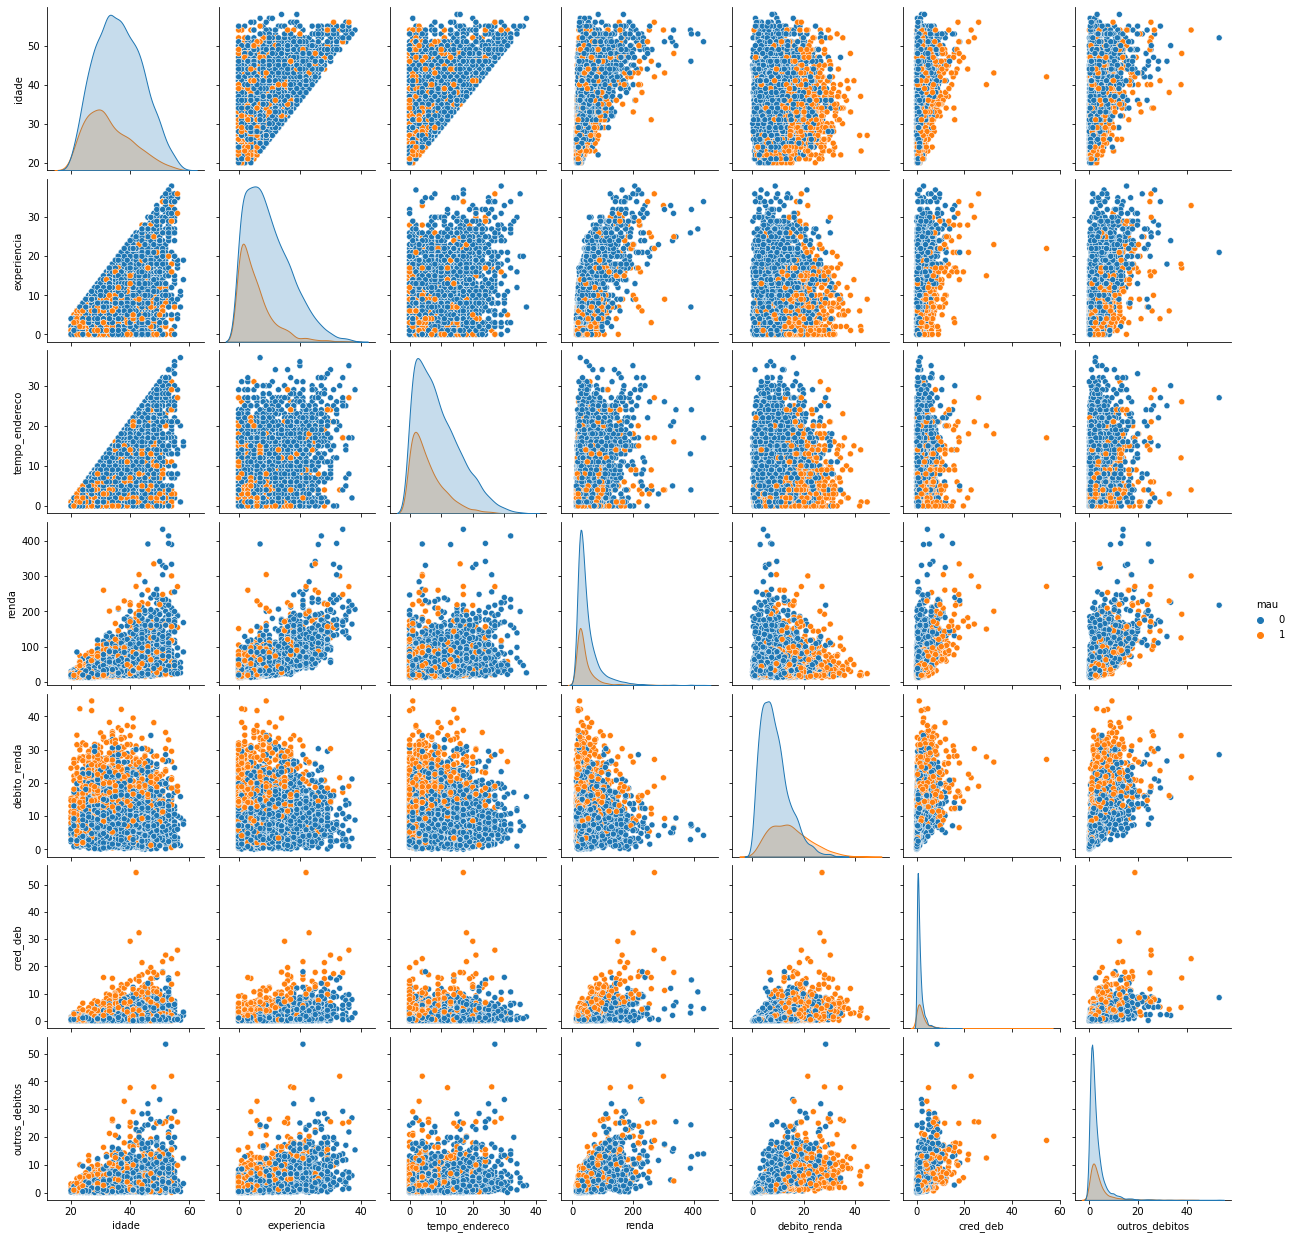

In [10]:
# b.4) segunda visualizacao de dados sem outlier

pairs = sns.pairplot(df_clean01, hue="mau")

# OBS> distribuicao de classes mau (0 e 1) apresentam forma normal ou lognormal em relacao as demais features.
# OBS2> aparentemente nao ha mais outliers significativos



In [11]:
# b.5) Visualizacao de dimensoes e estatisticas apos a retirada de outlier

print(df_clean01.shape)

df_clean01.describe()

(4999, 8)


idade  experiencia  tempo_endereco        renda  debito_renda  \
count  4999.000000  4999.000000     4999.000000  4999.000000   4999.000000   
mean     35.384477     8.702541        8.155431    47.194079     10.073481   
std       7.946865     7.194751        6.760705    38.947020      6.657649   
min      20.000000     0.000000        0.000000    12.100000      0.080000   
25%      29.000000     3.000000        3.000000    24.500000      5.050000   
50%      35.000000     7.000000        7.000000    34.500000      8.630000   
75%      41.000000    13.000000       12.000000    54.700000     13.680000   
max      58.000000    38.000000       37.000000   433.000000     44.620000   

          cred_deb  outros_debitos          mau  
count  4999.000000     4999.000000  4999.000000  
mean      1.600475        3.135906     0.251050  
std       2.348715        3.748647     0.433661  
min       0.005292        0.009373     0.000000  
25%       0.396071        0.989762     0.000000  
50%       0.906173        1.959243     0.000000  
75%       1.859039        3.784915     1.000000  
max      54.499042       53.401521     1.000000

In [12]:
# c) Qual o percentual de empréstimos não pagos (0 significa pago e 1 significa não pago ou "default" ou ainda "mau")?
#    mau = 0 (3744)
#    mau = 1 (1255)

(1255/(4999)*100) 

#  Percentual de emprestimos nao pagos  (1255/(4999)*100) = 25.10%

# a distribuicao de valores mau = 0 e mau = 1 esta desbalanceada em 3 para 1.   
 


25.10502100420084

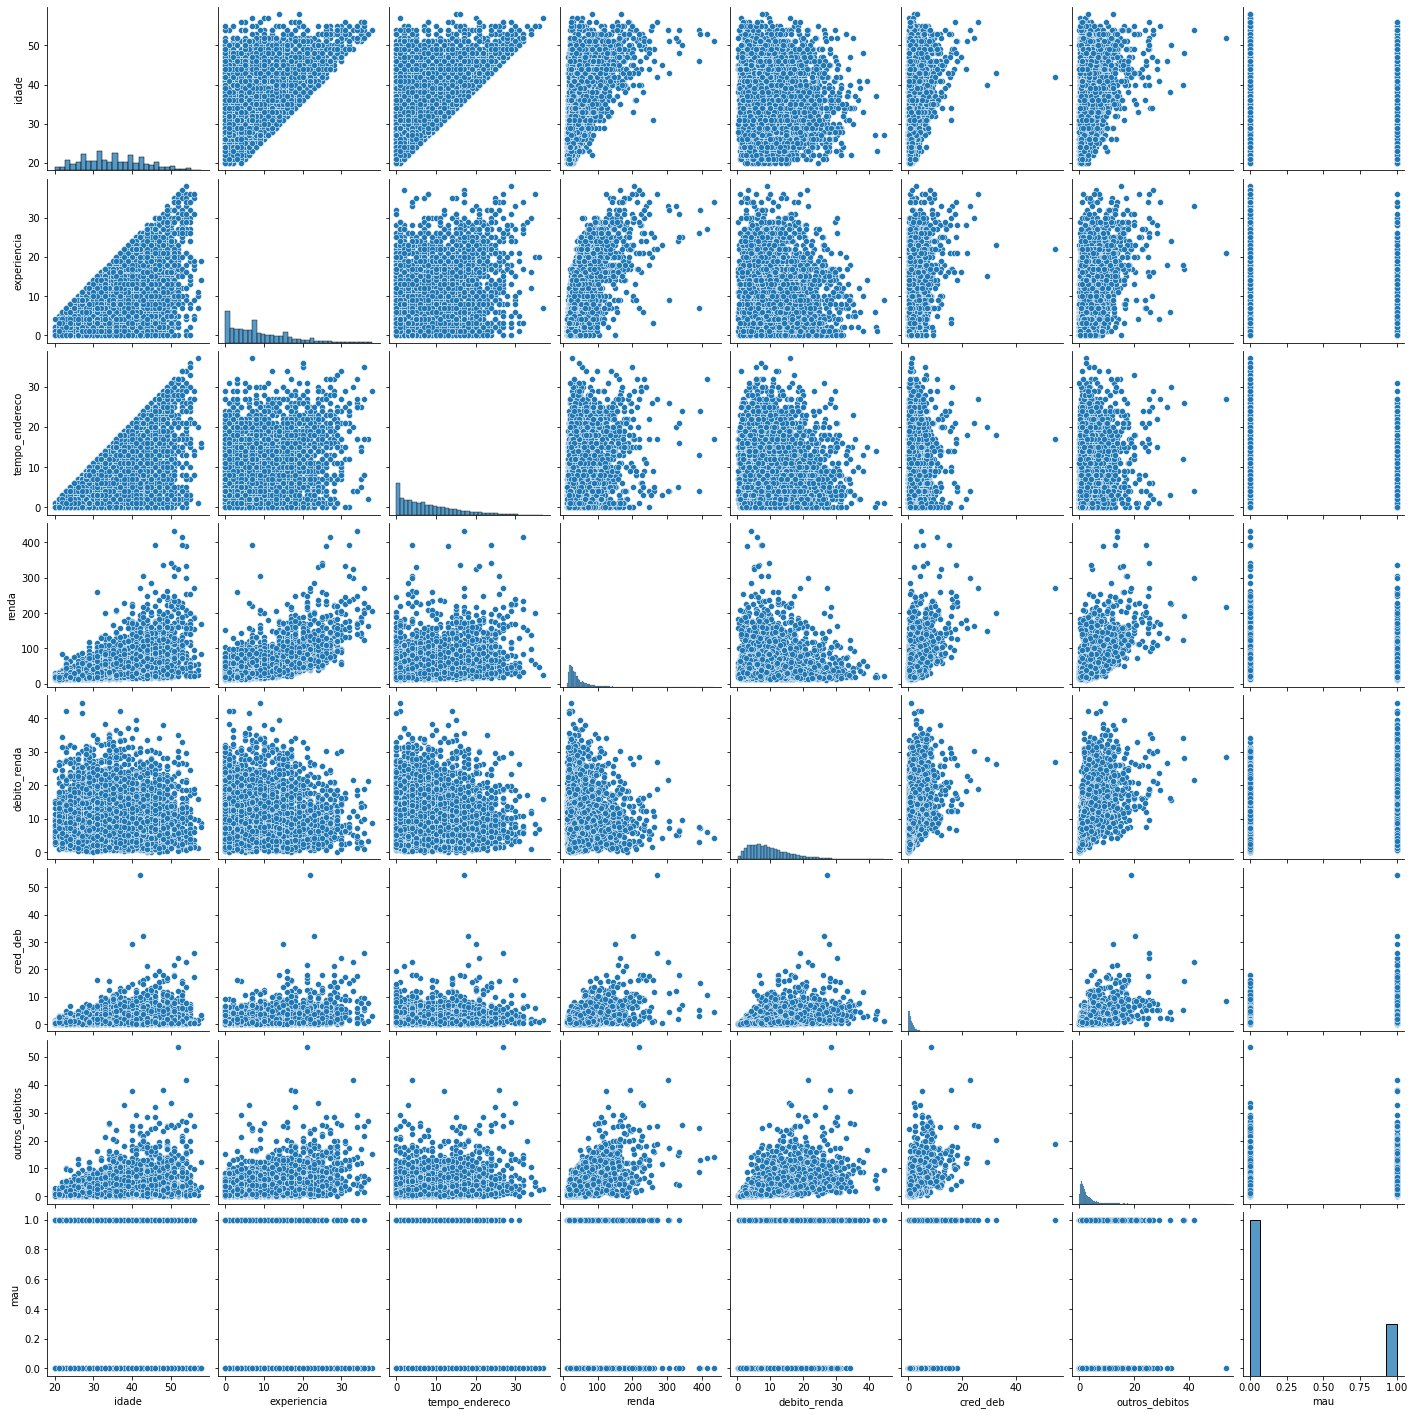

In [13]:
# d) Qual a correlação entre as variáveis presentes na base de dados? 
#    Categorize as variáveis e explique o método de categorização e explique o algoritmo usado na análise de 
#    correlação entre variáveis categóricas


# d.1) Visualizacao de distribuicoes e correlacoes com variavel mau.  

pairs = sns.pairplot(df_clean01)

# OBS> variaveis com relacao de debito (cred_deb, outros_debitos e debitos_renda) apresentam maior proporcao 
# de 1 (recusa).  As demais apresentam menos ou estao balanceadas.



In [14]:
# d.2) matriz de correlacao de todas as variaveis

df_clean01.corr()

# OBS>
#
# 5 maiores correlacoes entre variaveis independentes
# renda <-> experiencia        0.668820
# renda <-> outros_debitos     0.645412
# idade <-> tempo_endereco     0.581210
# cred_deb <-> outros_debitos  0.568293
# idade <-> experiencia        0.558918
#
#
# Correlacoes com variavel dependente (mau)
#                        mau  
# idade             -0.185233 (5) 
# experiencia       -0.259180 (2)
# tempo_endereco    -0.209376 (4) 
# renda             -0.076043 (7) 
# debito_renda       0.378949 (1)
# cred_deb           0.222784 (3) 
# outros_debitos     0.110854 (6)
# 

idade  experiencia  tempo_endereco     renda  debito_renda  \
idade           1.000000     0.558918        0.581210  0.511518     -0.020371   
experiencia     0.558918     1.000000        0.328645  0.668820     -0.016633   
tempo_endereco  0.581210     0.328645        1.000000  0.294006     -0.017257   
renda           0.511518     0.668820        0.294006  1.000000     -0.006830   
debito_renda   -0.020371    -0.016633       -0.017257 -0.006830      1.000000   
cred_deb        0.268634     0.361720        0.147269  0.554398      0.454631   
outros_debitos  0.337611     0.444621        0.196313  0.645412      0.534867   
mau            -0.185233    -0.259180       -0.209376 -0.076043      0.378949   

                cred_deb  outros_debitos       mau  
idade           0.268634        0.337611 -0.185233  
experiencia     0.361720        0.444621 -0.259180  
tempo_endereco  0.147269        0.196313 -0.209376  
renda           0.554398        0.645412 -0.076043  
debito_renda    0.454631        0.534867  0.378949  
cred_deb        1.000000        0.568293  0.222784  
outros_debitos  0.568293        1.000000  0.110854  
mau             0.222784        0.110854  1.000000

<AxesSubplot:>

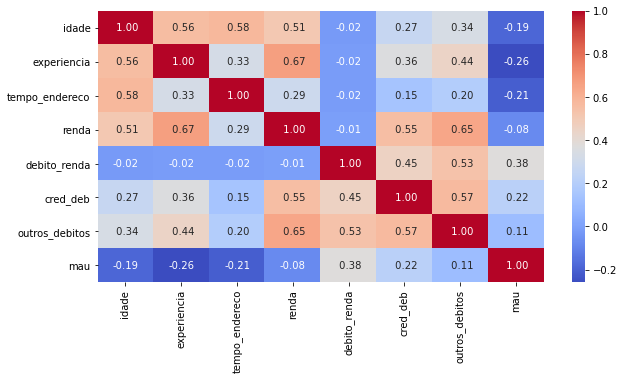

In [15]:
# d.3) heatmap de correlacoes entre todas as variaveis 

plt.figure(figsize=(10,5))
sns.heatmap(df_clean01.corr(),cbar=True,fmt =' .2f', annot=True, cmap='coolwarm')

In [16]:
# e) Quais são as variáveis que melhor explicam se o empréstimo foi pago ou não? 
#    (Aplique o conceito de Information Value)



In [17]:
# definicao de funcoes WOE e Information Value .  Ref: https://github.com/Sundar0989/WOE-and-IV/blob/master/WOE_IV.ipynb

# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [18]:
# e.1) separacao de variaveis features (X) e target (y))
X = df_clean01.drop('mau', axis=1)
y = df_clean01['mau']



In [19]:
# e.2) calculo de WOE e Information Values (IV)
#
#  WOE = In(% de Nao-eventos / % de Eventos)
#
#  Nao-eventos = Distribuicao de Bons pagadores - % de Bons clientes em determinada faixa (bins)
#  Eventos = Distribuicao de Maus pagadores - % de Maus clientes em determinada faixa (bins)
#  ln - Log Natural 
#
#
#  IV = ∑ (% Nao-eventos - % Eventos) * WOE
#
#  Se a estatística IV for:
#
#  Menor que 0,02, então o preditor não é útil para modelagem (separando os Bons dos Maus)
#  0,02 a 0,1, então o preditor tem apenas uma relação fraca com a razão de chances de bons / maus
#  0,1 a 0,3, então o preditor tem uma relação de força média com a razão de chances de bons / maus
#  0,3 a 0,5, então o preditor tem uma forte relação com a razão de chances de bons / maus.
#  > 0,5, relacionamento suspeito 

final_iv, IV = data_vars(X,y)

#  Resultado
#    VAR_NAME       IV
#  0 cred_deb       0.231711
#  1 debito_renda   0.694637
#  2 experiencia    0.463623
#  3 idade          0.206555
#  4 outros_debitos 0.112214
#  5 renda          0.091846
#  6 tempo_endereco 0.273136



In [20]:
final_iv

VAR_NAME  MIN_VALUE   MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
0            idade  20.000000   26.000000    731    304    0.415869       427   
1            idade  27.000000   30.000000    809    258    0.318912       551   
2            idade  31.000000   33.000000    705    188    0.266667       517   
3            idade  34.000000   36.000000    622    129    0.207395       493   
4            idade  37.000000   40.000000    766    154    0.201044       612   
5            idade  41.000000   45.000000    772    129    0.167098       643   
6            idade  46.000000   58.000000    594     93    0.156566       501   
7      experiencia   0.000000    1.000000    758    333    0.439314       425   
8      experiencia   2.000000    3.000000    665    254    0.381955       411   
9      experiencia   4.000000    4.000000    318    105    0.330189       213   
10     experiencia   5.000000    6.000000    595    171    0.287395       424   
11     experiencia   7.000000    8.000000    541    119    0.219963       422   
12     experiencia   9.000000   11.000000    631    109    0.172742       522   
13     experiencia  12.000000   14.000000    473     63    0.133192       410   
14     experiencia  15.000000   18.000000    475     56    0.117895       419   
15     experiencia  19.000000   38.000000    543     45    0.082873       498   
16  tempo_endereco   0.000000    1.000000    757    283    0.373844       474   
17  tempo_endereco   2.000000    2.000000    407    140    0.343980       267   
18  tempo_endereco   3.000000    4.000000    711    232    0.326301       479   
19  tempo_endereco   5.000000    6.000000    605    173    0.285950       432   
20  tempo_endereco   7.000000    7.000000    299     68    0.227425       231   
21  tempo_endereco   8.000000   10.000000    680    146    0.214706       534   
22  tempo_endereco  11.000000   13.000000    518     99    0.191120       419   
23  tempo_endereco  14.000000   17.000000    477     63    0.132075       414   
24  tempo_endereco  18.000000   37.000000    545     51    0.093578       494   
25           renda  12.100000   21.700000    836    299    0.357656       537   
26           renda  21.800000   27.400000    839    241    0.287247       598   
27           renda  27.500000   34.500000    832    208    0.250000       624   
28           renda  34.600000   45.300000    828    184    0.222222       644   
29           renda  45.400000   68.500000    831    166    0.199759       665   
30           renda  68.700000  433.000000    833    157    0.188475       676   
31    debito_renda   0.080000    3.520000    715     60    0.083916       655   
32    debito_renda   3.530000    5.550000    714     94    0.131653       620   
33    debito_renda   5.560000    7.580000    716    110    0.153631       606   
34    debito_renda   7.590000    9.840000    712    145    0.203652       567   
35    debito_renda   9.850000   12.700000    713    165    0.231417       548   
36    debito_renda  12.710000   17.170000    716    271    0.378492       445   
37    debito_renda  17.180000   44.620000    713    410    0.575035       303   
38        cred_deb   0.005292    0.240186    715    100    0.139860       615   
39        cred_deb   0.240677    0.461251    714    135    0.189076       579   
40        cred_deb   0.461430    0.735092    714    136    0.190476       578   
41        cred_deb   0.735459    1.088490    714    154    0.215686       560   
42        cred_deb   1.089360    1.664059    713    192    0.269285       521   
43        cred_deb   1.665808    2.851510    715    230    0.321678       485   
44        cred_deb   2.854852   54.499042    714    308    0.431373       406   
45  outros_debitos   0.009373    0.567321    556     77    0.138489       479   
46  outros_debitos   0.567464    0.903204    555    108    0.194595       447   
47  outros_debitos   0.903210    1.273079    556    118    0.212230       438   
48  outros_debitos   1.273763    1.699133

In [21]:
IV

VAR_NAME        IV
0        cred_deb  0.231711
1    debito_renda  0.694637
2     experiencia  0.463623
3           idade  0.206555
4  outros_debitos  0.112214
5           renda  0.091846
6  tempo_endereco  0.273136

In [22]:
# f) Ajuste um modelo logístico e avalie quais variáveis apareceram como significantes e quais não. Discuta o p-valor da regressão e, se for necessário, crie uma nova regressão com coeficientes estatisticamente significantes. Explique o significado do p-valor.
#
# A regressao logistica do SKLearn nao possui metodo para obtencao do p-value.  O contorno foi utilizar o (SM) Stats Model.
# Optimization terminated successfully.
#


In [23]:
# f.1) Execucao do Logit Regression (SM) para verificacao de p-values.  Regressao logistica no SKlearn nao possui apresentacao de p-values.  
# Observacoe no qustionario inicial

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.406630
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    mau   No. Observations:                 4999
Model:                          Logit   Df Residuals:                     4992
Method:                           MLE   Df Model:                            6
Date:                Wed, 07 Jul 2021   Pseudo R-squ.:                  0.2784
Time:                        18:21:29   Log-Likelihood:                -2032.7
converged:                       True   LL-Null:                       -2816.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
idade             -0.0209      0.004     -4.704      0.000      -0.030      -0.012
experiencia      

In [24]:
# f.2)
# 
# Todas features sao significativas (p-value <0.05) com renda (p-value 0.029) e outros_debitos (p-value 0.005) com menor significancia.
# 
# O p-value para cada feature testa a hipotese nula de que o coeficiente desta é igual a zero (sem efeito para a variavel dependente). 
# Um valor de p-value baixo (<0,05) indica que podemos rejeitar a hipótese nula e a feature deve ser considerada significativa. 
# Uma feature que possui um p-value baixo (<0,05) provavelmente será uma adição significativa ao seu modelo porque as 
# mudanças no seu valor estarão relacionadas às mudanças na variável dependente.

In [25]:
# g) Calcule o score de propensão a default como uma coluna nova na base (Probabilidade de ser "default" ou P(mau=1))


In [26]:
# g.1)  teste de score com decision trees

In [27]:
tree = DecisionTreeClassifier()

In [28]:
# g.1.1) teste de score do modelo de decision trees com todas as features

X_train, X_test, y_train, y_test = train_test_split(df_clean01.drop('mau', axis=1), df_clean01['mau'])
tree.fit(X_train, y_train)
print('Score {}'.format(tree.score(X_test, y_test)))


Score 0.7128


In [29]:
# g.1.2) teste de score do modelo de decision trees variando o descarte de features, 

for col in df_clean01.columns:
    X_train, X_test, y_train, y_test = train_test_split(df_clean01.drop([col, 'mau'], axis=1), df_clean01['mau']) 
    tree.fit(X_train, y_train)
    print('Drop Feature {} com score {}'.format(col, tree.score(X_test, y_test)))

Drop Feature idade com score 0.7216
Drop Feature experiencia com score 0.6904
Drop Feature tempo_endereco com score 0.7256
Drop Feature renda com score 0.72
Drop Feature debito_renda com score 0.7384
Drop Feature cred_deb com score 0.712
Drop Feature outros_debitos com score 0.7288
Drop Feature mau com score 0.7112


In [30]:
# g.2)  teste de score com Random forest

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(max_depth=2, random_state=0)


In [31]:
# g.2.1)  teste de score com Random forest

X_train, X_test, y_train, y_test = train_test_split(df_clean01.drop('mau', axis=1), df_clean01['mau'])

RF.fit(X_train, y_train)

print('Score {}'.format(RF.score(X_test, y_test)))


Score 0.7512


In [32]:
# g.2.2) teste de score do modelo Random Forest variando o descarte de features, 

for col in df_clean01.columns:
    X_train, X_test, y_train, y_test = train_test_split(df_clean01.drop([col, 'mau'], axis=1), df_clean01['mau'])
    RF.fit(X_train, y_train)
    print('Drop Feature {} com score {}'.format(col, RF.score(X_test, y_test)))

Drop Feature idade com score 0.7736
Drop Feature experiencia com score 0.7792
Drop Feature tempo_endereco com score 0.764
Drop Feature renda com score 0.7592
Drop Feature debito_renda com score 0.7488
Drop Feature cred_deb com score 0.7504
Drop Feature outros_debitos com score 0.7536
Drop Feature mau com score 0.7504


In [33]:
# g.3) teste de score de modelo de regressao logistica 

In [34]:
# g.3.1) teste de score do modelo  com todas as features

LogReg = LogisticRegression(solver = 'lbfgs', max_iter = 200)

X_train, X_test, y_train, y_test = train_test_split(df_clean01.drop('mau', axis=1), df_clean01['mau'])
LogReg.fit(X_train, y_train)
print('Score {}'.format(LogReg.score(X_test, y_test)))

Score 0.8128


In [35]:
# g.3.2) teste de score do modelo variando o descarte de features 

for col in df_clean01.columns:
    X_train, X_test, y_train, y_test = train_test_split(df_clean01.drop([col, 'mau'], axis=1), df_clean01['mau'])
    LogReg.fit(X_train, y_train)
    print('Drop Feature {} com score {}'.format(col, LogReg.score(X_test, y_test)))


Drop Feature idade com score 0.7888
Drop Feature experiencia com score 0.8088
Drop Feature tempo_endereco com score 0.7936
Drop Feature renda com score 0.8072
Drop Feature debito_renda com score 0.8072
Drop Feature cred_deb com score 0.7864
Drop Feature outros_debitos com score 0.8072
Drop Feature mau com score 0.8112


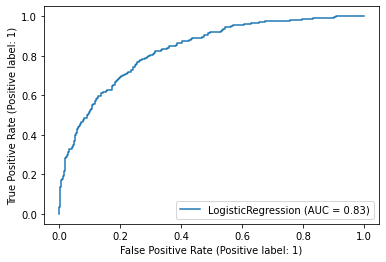

In [36]:
# g.3.3) Verificacao de score de AUC para regressao logistica.   

X_train, X_test, y_train, y_test = train_test_split(df_clean01.drop('mau', axis=1), df_clean01['mau'])

metrics.plot_roc_curve(LogReg, X_test, y_test)  
plt.show() 

In [37]:
# g.3.4) Calculode probabilidades para variavel dependente (Regressao logistica)

df_clean_prob = LogReg.predict_proba(X)

df_clean_prob



array([[0.97900535, 0.02099465],
       [0.86023811, 0.13976189],
       [0.93060526, 0.06939474],
       ...,
       [0.1950985 , 0.8049015 ],
       [0.98814574, 0.01185426],
       [0.98554979, 0.01445021]])

In [38]:
clean_predict = LogReg.predict(X)
clean_predict

array([0, 0, 0, ..., 1, 0, 0])

In [39]:
# g.3.4.1)  Conversao de array de probabilidades P(mau)/P(mau) para dataframe

df_probs = pd.DataFrame(df_clean_prob, columns=['P(mau)', '1 - P(mau)'])
df_clean_predict = pd.DataFrame(clean_predict)

df_probs['predict'] = df_clean_predict
df_probs['mau'] = df_clean01['mau']


In [40]:
df_probs

P(mau)  1 - P(mau)  predict  mau
0     0.979005    0.020995        0  0.0
1     0.860238    0.139762        0  0.0
2     0.930605    0.069395        0  0.0
3     0.563174    0.436826        0  0.0
4     0.967349    0.032651        0  0.0
...        ...         ...      ...  ...
4994  0.799339    0.200661        0  0.0
4995  0.913546    0.086454        0  0.0
4996  0.195098    0.804902        1  0.0
4997  0.988146    0.011854        0  1.0
4998  0.985550    0.014450        0  0.0

[4999 rows x 4 columns]

In [41]:
# g.3.4.2) Adicao da coluna de probabilidade de default aos registros

df_clean01['P(mau)'] = df_probs['P(mau)']

<ipython-input-41-51b7590818ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean01['P(mau)'] = df_probs['P(mau)']


In [42]:
# g.3.4.3) Inspecao do Data Frame df_clean01 com coluna de probabilidades adicionada

df_clean01.head(5)

idade  experiencia  tempo_endereco  renda  debito_renda  cred_deb  \
0     41           17              12   35.9         11.90  0.504108   
1     30           13               8   46.7         17.88  1.352694   
2     40           15              14   61.8         10.64  3.438997   
3     41           15              14   72.0         29.67  4.165668   
4     57            7              37   25.6         15.86  1.498199   

   outros_debitos  mau    P(mau)  
0        3.767992    0  0.979005  
1        6.997266    0  0.860238  
2        3.136523    0  0.930605  
3       17.196732    0  0.563174  
4        2.561961    0  0.967349

In [43]:
# h) Qual a sugestão inicial de ponto de corte para predizer se o empréstimo será pago ou não?
# 
#       P(mau=0) >= 0.5  ->  mau = 1
#       P(mau=0)  < 0.5  ->  mau = 0

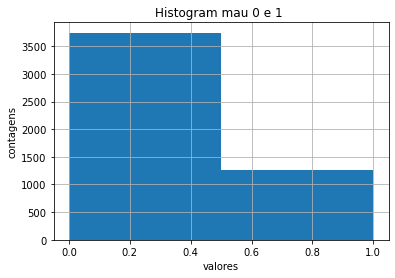

In [44]:
# h.1) Distribuicao real de bons (0) e maus (1) pagadores 

plt.hist(df_clean01['mau'], bins=2)

plt.xlabel('valores')
plt.ylabel('contagens')
plt.title('Histogram mau 0 e 1 ')

plt.grid(True)

plt.show()

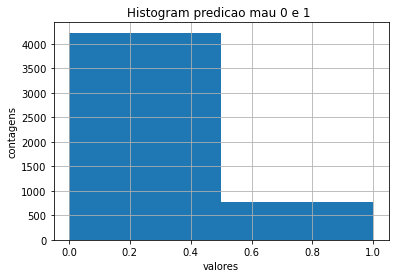

In [45]:
plt.hist(df_clean_predict, bins=2)

plt.xlabel('valores')
plt.ylabel('contagens')
plt.title('Histogram predicao mau 0 e 1 ')

plt.grid(True)

plt.show()

In [46]:
# i) Considerando essa sugestão, desenhe a matriz de confusão e calcule a sensibilidade e especificidade.
# 
# 
 

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df_clean01.drop(['mau','P(mau)'], axis=1), df_clean01['mau'])

In [48]:
# i.1.1) geracao da matriz de confusao entre valores reais da reais (y) e valores previstos (df_clean_predict)

df_clean_predict = LogReg.predict(X_test)

cm = confusion_matrix(y_test, df_clean_predict)


In [49]:
#       Sensibilidade - TPR = TP/(TP+FN)  
#       Especificidade - TNR = TN/(TN+FP) 

In [50]:
TP = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TN = cm[1,1]


print('Confuzion Matrix')
print(TP, FN)
print(FP, TN)

TPR = TP/(TP+FN)
TNR = TN/(TN+FP)

print('Sensibilidade:  ' + str(TPR))
print('Especificidade: ' + str(TNR))

Confuzion Matrix
873 56
182 139
Sensibilidade:  0.9397201291711518
Especificidade: 0.43302180685358255


In [51]:
# OBS> Alta sensibilidade e baixa especificidade

In [52]:
# j) Use as métricas de KS e ROC / AUC para avaliar o poder de separação entre os grupos ("1" e "0").
# 

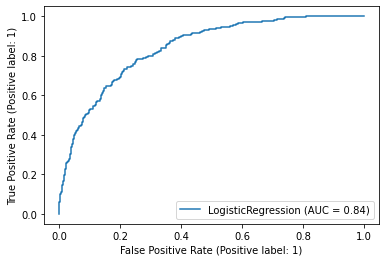

In [53]:
metrics.plot_roc_curve(LogReg, X_test, y_test)  
plt.show() 

In [54]:
from scipy import stats

stats.ks_2samp(y_test, df_clean_predict)

KstestResult(statistic=0.1008, pvalue=5.997644086697686e-06)

In [55]:
# k) Avalie a discriminação por faixas de Score para a variável "default". Existe alguma inversão? Faça para 5 grupos (quintil) e 10 grupos (decil).

In [56]:
# separacao de registros por valor da variavel dependente

df_clean_mau0 = df_clean01[df_clean01['mau'] == 0]
df_clean_mau1 = df_clean01[df_clean01['mau'] == 1]

print('mau = 0', df_clean_mau0.shape)
print('mau = 1', df_clean_mau1.shape)

mau = 0 (3744, 9)
mau = 1 (1255, 9)


In [57]:
df_clean_mau0.head()

idade  experiencia  tempo_endereco  renda  debito_renda  cred_deb  \
0     41           17              12   35.9         11.90  0.504108   
1     30           13               8   46.7         17.88  1.352694   
2     40           15              14   61.8         10.64  3.438997   
3     41           15              14   72.0         29.67  4.165668   
4     57            7              37   25.6         15.86  1.498199   

   outros_debitos  mau    P(mau)  
0        3.767992    0  0.979005  
1        6.997266    0  0.860238  
2        3.136523    0  0.930605  
3       17.196732    0  0.563174  
4        2.561961    0  0.967349

In [58]:
df_clean_mau0.describe()

idade  experiencia  tempo_endereco        renda  debito_renda  \
count  3744.000000  3744.000000     3744.000000  3744.000000   3744.000000   
mean     36.236645     9.782051        8.974893    48.908600      8.612946   
std       7.826163     7.325167        6.992833    39.388314      5.497911   
min      20.000000     0.000000        0.000000    12.300000      0.080000   
25%      30.000000     4.000000        3.000000    25.500000      4.480000   
50%      36.000000     8.000000        7.000000    35.900000      7.570000   
75%      42.000000    14.000000       13.000000    56.925000     11.540000   
max      58.000000    38.000000       37.000000   433.000000     34.250000   

          cred_deb  outros_debitos     mau       P(mau)  
count  3744.000000     3744.000000  3744.0  3743.000000  
mean      1.297557        2.895339     0.0     0.811005  
std       1.590465        3.464627     0.0     0.191975  
min       0.005292        0.009373     0.0     0.000104  
25%       0.350709        0.907506     0.0     0.725485  
50%       0.790265        1.796636     0.0     0.878629  
75%       1.596514        3.543913     0.0     0.957494  
max      18.044636       53.401521     0.0     0.999911

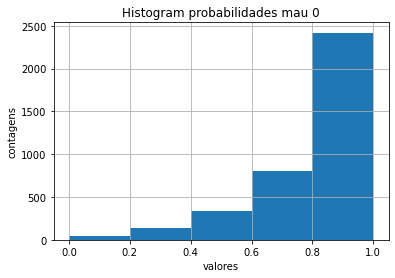

In [59]:
plt.hist(df_clean_mau0['P(mau)'], bins=5)

plt.xlabel('valores')
plt.ylabel('contagens')
plt.title('Histogram probabilidades mau 0')

plt.grid(True)

plt.show()

In [60]:
df_clean_mau1.head()

idade  experiencia  tempo_endereco  renda  debito_renda  cred_deb  \
6      36            1               3   19.6         12.82  1.211131   
11     37           17              10   78.3         25.44  7.091349   
13     36            8               1   48.1          5.28  0.736507   
19     45            2              26   34.8          4.98  1.225259   
21     48            1              11   17.4         13.44  0.240872   

    outros_debitos  mau    P(mau)  
6         1.301589    1  0.422518  
11       12.828171    1  0.389801  
13        1.803173    1  0.852907  
19        0.507781    1  0.937317  
21        2.097688    1  0.665126

In [61]:
df_clean_mau1.describe()


idade  experiencia  tempo_endereco        renda  debito_renda  \
count  1255.000000  1255.000000     1255.000000  1255.000000   1255.000000   
mean     32.842231     5.482072        5.710757    42.079203     14.430645   
std       7.762049     5.682828        5.313010    37.147513      7.814664   
min      20.000000     0.000000        0.000000    12.100000      0.480000   
25%      27.000000     1.000000        2.000000    22.050000      8.255000   
50%      31.000000     4.000000        4.000000    30.100000     13.550000   
75%      38.000000     8.000000        8.000000    46.450000     19.390000   
max      56.000000    36.000000       31.000000   334.900000     44.620000   

          cred_deb  outros_debitos     mau        P(mau)  
count  1255.000000     1255.000000  1255.0  1.255000e+03  
mean      2.504159        3.853582     1.0  5.874573e-01  
std       3.653081        4.414794     0.0  2.705161e-01  
min       0.010329        0.062276     1.0  8.402166e-09  
25%       0.609605        1.300234     1.0  3.902423e-01  
50%       1.352117        2.501111     1.0  6.274889e-01  
75%       2.818770        4.516529     1.0  8.087250e-01  
max      54.499042       41.873309     1.0  9.998256e-01

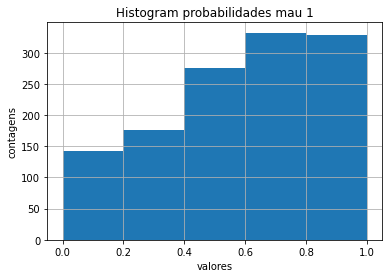

In [62]:
plt.hist(df_clean_mau1['P(mau)'], bins=5)

plt.xlabel('valores')
plt.ylabel('contagens')
plt.title('Histogram probabilidades mau 1')

plt.grid(True)

plt.show()

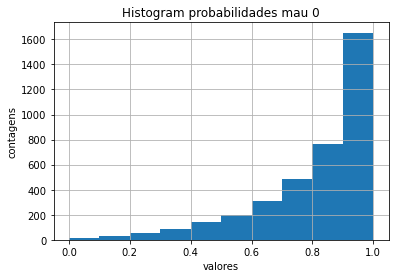

In [63]:
plt.hist(df_clean_mau0['P(mau)'], bins=10)

plt.xlabel('valores')
plt.ylabel('contagens')
plt.title('Histogram probabilidades mau 0')

plt.grid(True)

plt.show()

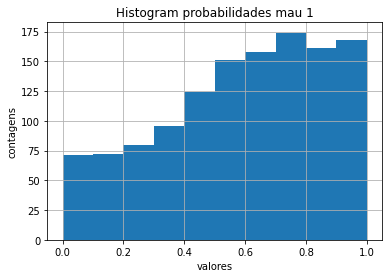

In [64]:
plt.hist(df_clean_mau1['P(mau)'], bins=10)

plt.xlabel('valores')
plt.ylabel('contagens')
plt.title('Histogram probabilidades mau 1')

plt.grid(True)

plt.show()

In [65]:
# L) testes com engenharia de features

df_clean02 = df[df['renda'] < 500]


In [66]:
df_clean02.columns

Index(['idade', 'experiencia', 'tempo_endereco', 'renda', 'debito_renda',
       'cred_deb', 'outros_debitos', 'mau'],
      dtype='object')

In [67]:
cols = ['idade', 'experiencia', 'tempo_endereco', 'renda', 'debito_renda', 'cred_deb', 'outros_debitos']

In [68]:
df_clean02.describe()

idade  experiencia  tempo_endereco        renda  debito_renda  \
count  4999.000000  4999.000000     4999.000000  4999.000000   4999.000000   
mean     35.384477     8.702541        8.155431    47.194079     10.073481   
std       7.946865     7.194751        6.760705    38.947020      6.657649   
min      20.000000     0.000000        0.000000    12.100000      0.080000   
25%      29.000000     3.000000        3.000000    24.500000      5.050000   
50%      35.000000     7.000000        7.000000    34.500000      8.630000   
75%      41.000000    13.000000       12.000000    54.700000     13.680000   
max      58.000000    38.000000       37.000000   433.000000     44.620000   

          cred_deb  outros_debitos          mau  
count  4999.000000     4999.000000  4999.000000  
mean      1.600475        3.135906     0.251050  
std       2.348715        3.748647     0.433661  
min       0.005292        0.009373     0.000000  
25%       0.396071        0.989762     0.000000  
50%       0.906173        1.959243     0.000000  
75%       1.859039        3.784915     1.000000  
max      54.499042       53.401521     1.000000

In [69]:
# Normalizacao de valores

for i in cols:
    df_clean02[i] = df_clean02[i]/df_clean02[i].max()

    
    

<ipython-input-69-b65d31507a88>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean02[i] = df_clean02[i]/df_clean02[i].max()


In [70]:
df_clean02.describe()

idade  experiencia  tempo_endereco        renda  debito_renda  \
count  4999.000000  4999.000000     4999.000000  4999.000000   4999.000000   
mean      0.610077     0.229014        0.220417     0.108993      0.225762   
std       0.137015     0.189336        0.182722     0.089947      0.149208   
min       0.344828     0.000000        0.000000     0.027945      0.001793   
25%       0.500000     0.078947        0.081081     0.056582      0.113178   
50%       0.603448     0.184211        0.189189     0.079677      0.193411   
75%       0.706897     0.342105        0.324324     0.126328      0.306589   
max       1.000000     1.000000        1.000000     1.000000      1.000000   

          cred_deb  outros_debitos          mau  
count  4999.000000     4999.000000  4999.000000  
mean      0.029367        0.058723     0.251050  
std       0.043096        0.070197     0.433661  
min       0.000097        0.000176     0.000000  
25%       0.007267        0.018534     0.000000  
50%       0.016627        0.036689     0.000000  
75%       0.034111        0.070877     1.000000  
max       1.000000        1.000000     1.000000

In [71]:
# suavizacao de distribuicoes com SQRT

for i in cols:
    df_clean02[i] = df_clean02[i].transform(np.sqrt)

<ipython-input-71-96df3463bc23>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean02[i] = df_clean02[i].transform(np.sqrt)


In [72]:
df_clean02.describe()

idade  experiencia  tempo_endereco        renda  debito_renda  \
count  4999.000000  4999.000000     4999.000000  4999.000000   4999.000000   
mean      0.776141     0.426501        0.419354     0.312152      0.449044   
std       0.087660     0.217073        0.211112     0.107502      0.155325   
min       0.587220     0.000000        0.000000     0.167166      0.042343   
25%       0.707107     0.280976        0.284747     0.237870      0.336419   
50%       0.776819     0.429198        0.434959     0.282271      0.439785   
75%       0.840771     0.584898        0.569495     0.355426      0.553705   
max       1.000000     1.000000        1.000000     1.000000      1.000000   

          cred_deb  outros_debitos          mau  
count  4999.000000     4999.000000  4999.000000  
mean      0.146781        0.214833     0.251050  
std       0.088454        0.112128     0.433661  
min       0.009854        0.013248     0.000000  
25%       0.085249        0.136141     0.000000  
50%       0.128947        0.191543     0.000000  
75%       0.184693        0.266226     1.000000  
max       1.000000        1.000000     1.000000

In [73]:
# deslocamento da media para o zero

for i in cols:
    df_clean02[i] = df_clean02[i] - df_clean02[i].mean()

<ipython-input-73-681bf366cee0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean02[i] = df_clean02[i] - df_clean02[i].mean()


In [74]:
df_clean02.describe()

idade   experiencia  tempo_endereco         renda  debito_renda  \
count  4.999000e+03  4.999000e+03    4.999000e+03  4.999000e+03  4.999000e+03   
mean   6.856466e-15  1.212340e-15    1.053852e-14 -6.633744e-16  2.552636e-16   
std    8.766042e-02  2.170731e-01    2.111124e-01  1.075015e-01  1.553252e-01   
min   -1.889205e-01 -4.265008e-01   -4.193537e-01 -1.449859e-01 -4.067011e-01   
25%   -6.903391e-02 -1.455251e-01   -1.346063e-01 -7.428251e-02 -1.126247e-01   
50%    6.786396e-04  2.696732e-03    1.560512e-02 -2.988162e-02 -9.258749e-03   
75%    6.463071e-02  1.583968e-01    1.501411e-01  4.327424e-02  1.046608e-01   
max    2.238593e-01  5.734992e-01    5.806463e-01  6.878478e-01  5.509560e-01   

           cred_deb  outros_debitos          mau  
count  4.999000e+03    4.999000e+03  4999.000000  
mean  -5.925779e-16   -8.356655e-16     0.251050  
std    8.845364e-02    1.121275e-01     0.433661  
min   -1.369265e-01   -2.015844e-01     0.000000  
25%   -6.153109e-02   -7.869181e-02     0.000000  
50%   -1.783363e-02   -2.328922e-02     0.000000  
75%    3.791213e-02    5.139375e-02     1.000000  
max    8.532194e-01    7.851673e-01     1.000000

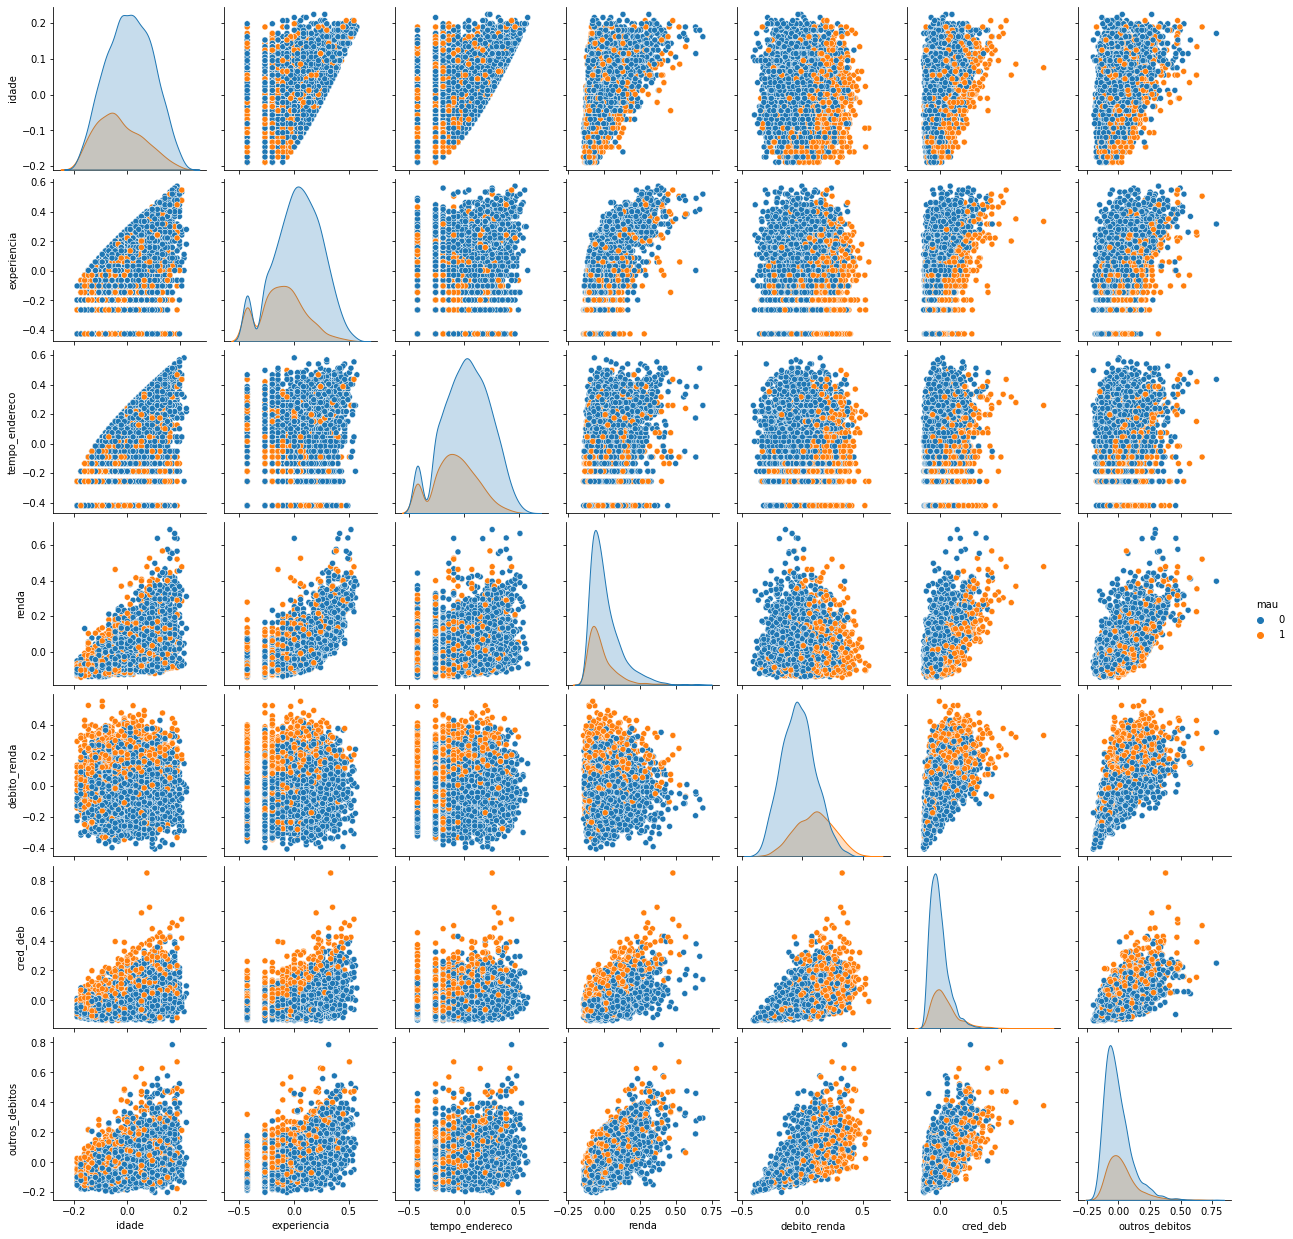

In [75]:
pairs = sns.pairplot(df_clean02, hue='mau')

In [76]:
LogReg = LogisticRegression(solver = 'lbfgs', max_iter = 200)

X_train, X_test, y_train, y_test = train_test_split(df_clean02.drop('mau', axis=1), df_clean02['mau'])
LogReg.fit(X_train, y_train)
print('Score {}'.format(LogReg.score(X_test, y_test)))

Score 0.7976


In [77]:
# Overbalance

overbalance = df_clean02[df_clean02['mau']==1]

In [78]:
df_overbalanced = pd.concat([df_clean02, overbalance], ignore_index=True)

In [79]:
df_overbalanced = pd.concat([df_overbalanced, overbalance], ignore_index=True)

In [80]:
df_overbalanced

idade  experiencia  tempo_endereco     renda  debito_renda  cred_deb  \
0     0.064631     0.242355        0.150141 -0.024211      0.067383 -0.050604   
1    -0.056946     0.158397        0.045637  0.016256      0.183978  0.010765   
2     0.054314     0.201780        0.195771  0.065638      0.039278  0.104420   
3     0.064631     0.201780        0.195771  0.095624      0.366400  0.129689   
4     0.215201     0.002697        0.580646 -0.069001      0.147149  0.019022   
...        ...          ...             ...       ...           ...       ...   
7504 -0.132873    -0.029141       -0.186858 -0.093506      0.089893 -0.070567   
7505 -0.146417    -0.426501       -0.090556  0.013076      0.114092 -0.018215   
7506  0.064631    -0.063763        0.315861 -0.037344     -0.010790  0.036322   
7507  0.043868    -0.426501        0.125896  0.024589      0.119440  0.098210   
7508 -0.045057    -0.145525       -0.134606 -0.104337      0.296479  0.045616   

      outros_debitos  mau  
0           0.050798    0  
1           0.147150    0  
2           0.027520    0  
3           0.352642    0  
4           0.004200    0  
...              ...  ...  
7504       -0.004336    1  
7505        0.108415    1  
7506       -0.079695    1  
7507        0.052245    1  
7508        0.006678    1  

[7509 rows x 8 columns]

(array([3744.,    0., 3765.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

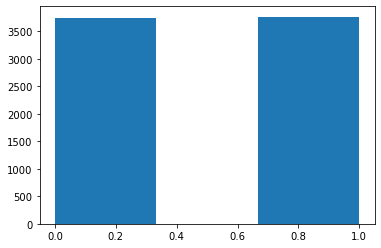

In [81]:
plt.hist(df_overbalanced['mau'], bins=3)

In [82]:
LogReg = LogisticRegression(solver = 'lbfgs', max_iter = 200)

X_train, X_test, y_train, y_test = train_test_split(df_overbalanced.drop('mau', axis=1), df_overbalanced['mau'])
LogReg.fit(X_train, y_train)
print('Score {}'.format(LogReg.score(X_test, y_test)))

Score 0.7598509052183173


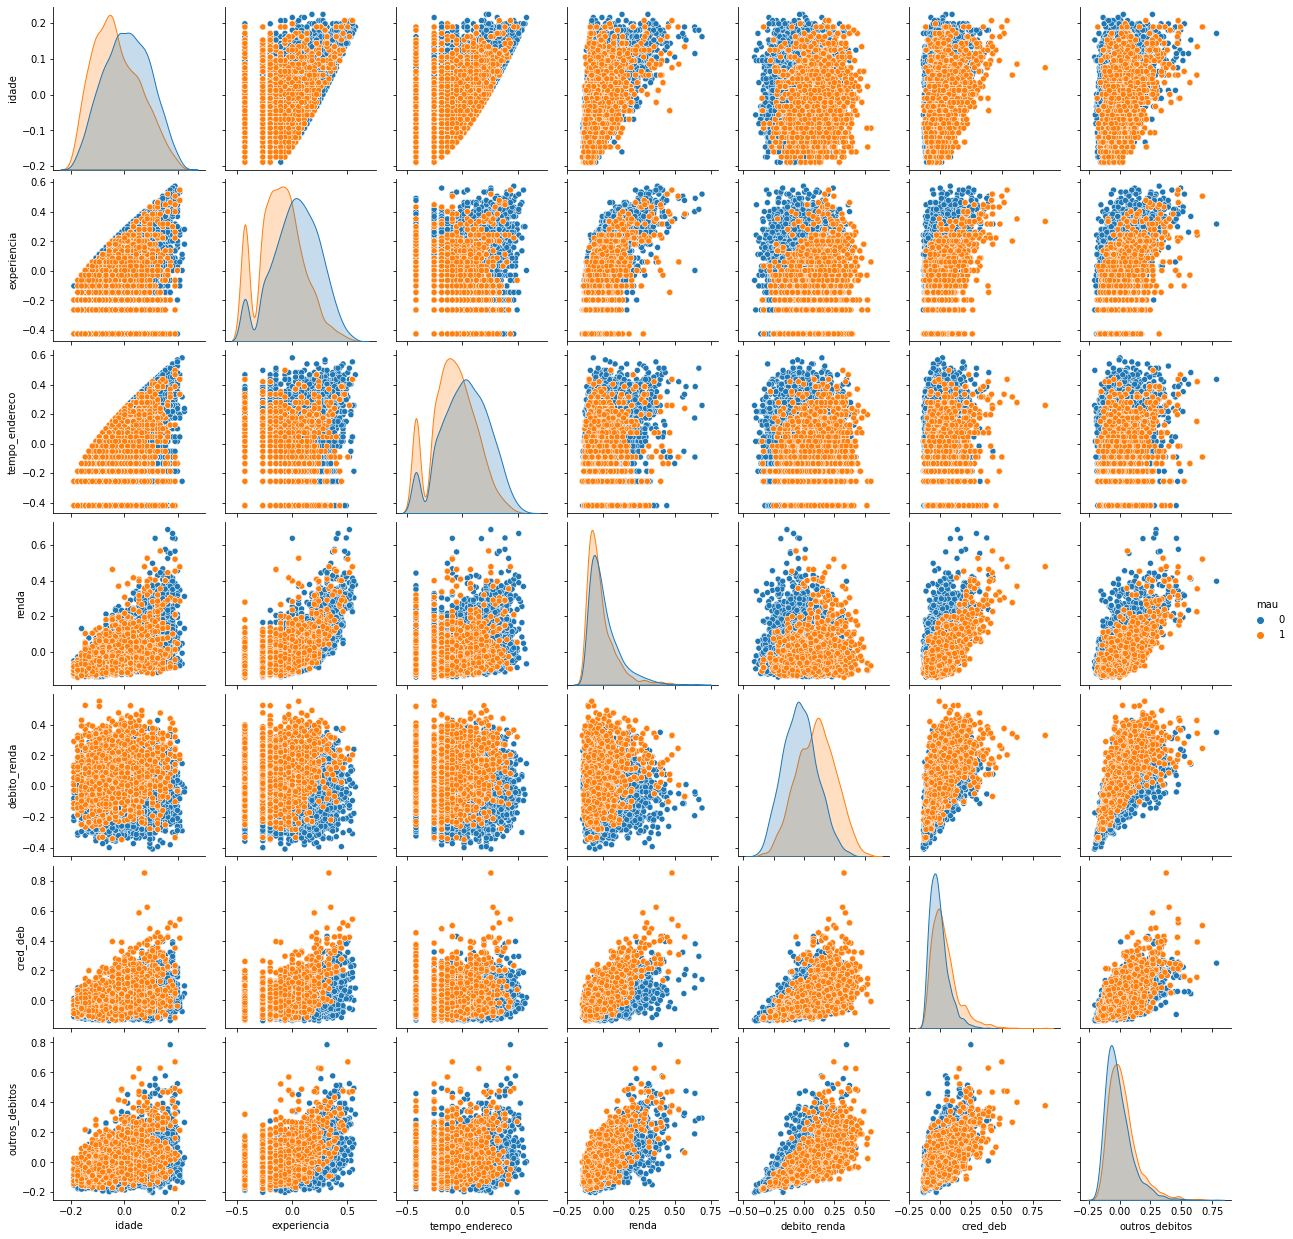

In [83]:
pairs = sns.pairplot(df_overbalanced, hue='mau')

In [84]:
# Underbalance

underbalance = df_clean02[df_clean02['mau']==0]
underbalance = underbalance[0:1255]

In [85]:
df_underbalanced = pd.concat([underbalance, overbalance], ignore_index=True)

In [86]:
df_underbalanced.describe()

idade  experiencia  tempo_endereco        renda  debito_renda  \
count  2510.000000  2510.000000     2510.000000  2510.000000   2510.000000   
mean     -0.010234    -0.035373       -0.024257    -0.007767      0.033621   
std       0.088933     0.216446        0.208298     0.105305      0.162583   
min      -0.188920    -0.426501       -0.419354    -0.144986     -0.406701   
25%      -0.081332    -0.197085       -0.186858    -0.080181     -0.082879   
50%      -0.010499    -0.029141       -0.016660    -0.036505      0.026489   
75%       0.054314     0.111527        0.125896     0.031715      0.145219   
max       0.223859     0.573499        0.580646     0.687848      0.550956   

          cred_deb  outros_debitos        mau  
count  2510.000000     2510.000000  2510.0000  
mean      0.011344        0.008171     0.5000  
std       0.098160        0.114395     0.5001  
min      -0.136927       -0.201584     0.0000  
25%      -0.054609       -0.071561     0.0000  
50%      -0.009178       -0.013772     0.5000  
75%       0.051525        0.059642     1.0000  
max       0.853219        0.670674     1.0000

(array([1255.,    0., 1255.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

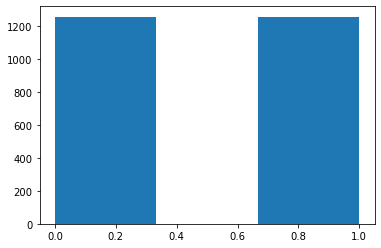

In [87]:
plt.hist(df_underbalanced['mau'], bins=3)

In [88]:
LogReg = LogisticRegression(solver = 'lbfgs', max_iter = 200)

X_train, X_test, y_train, y_test = train_test_split(df_underbalanced.drop('mau', axis=1), df_underbalanced['mau'])
LogReg.fit(X_train, y_train)
print('Score {}'.format(LogReg.score(X_test, y_test)))

Score 0.7563694267515924


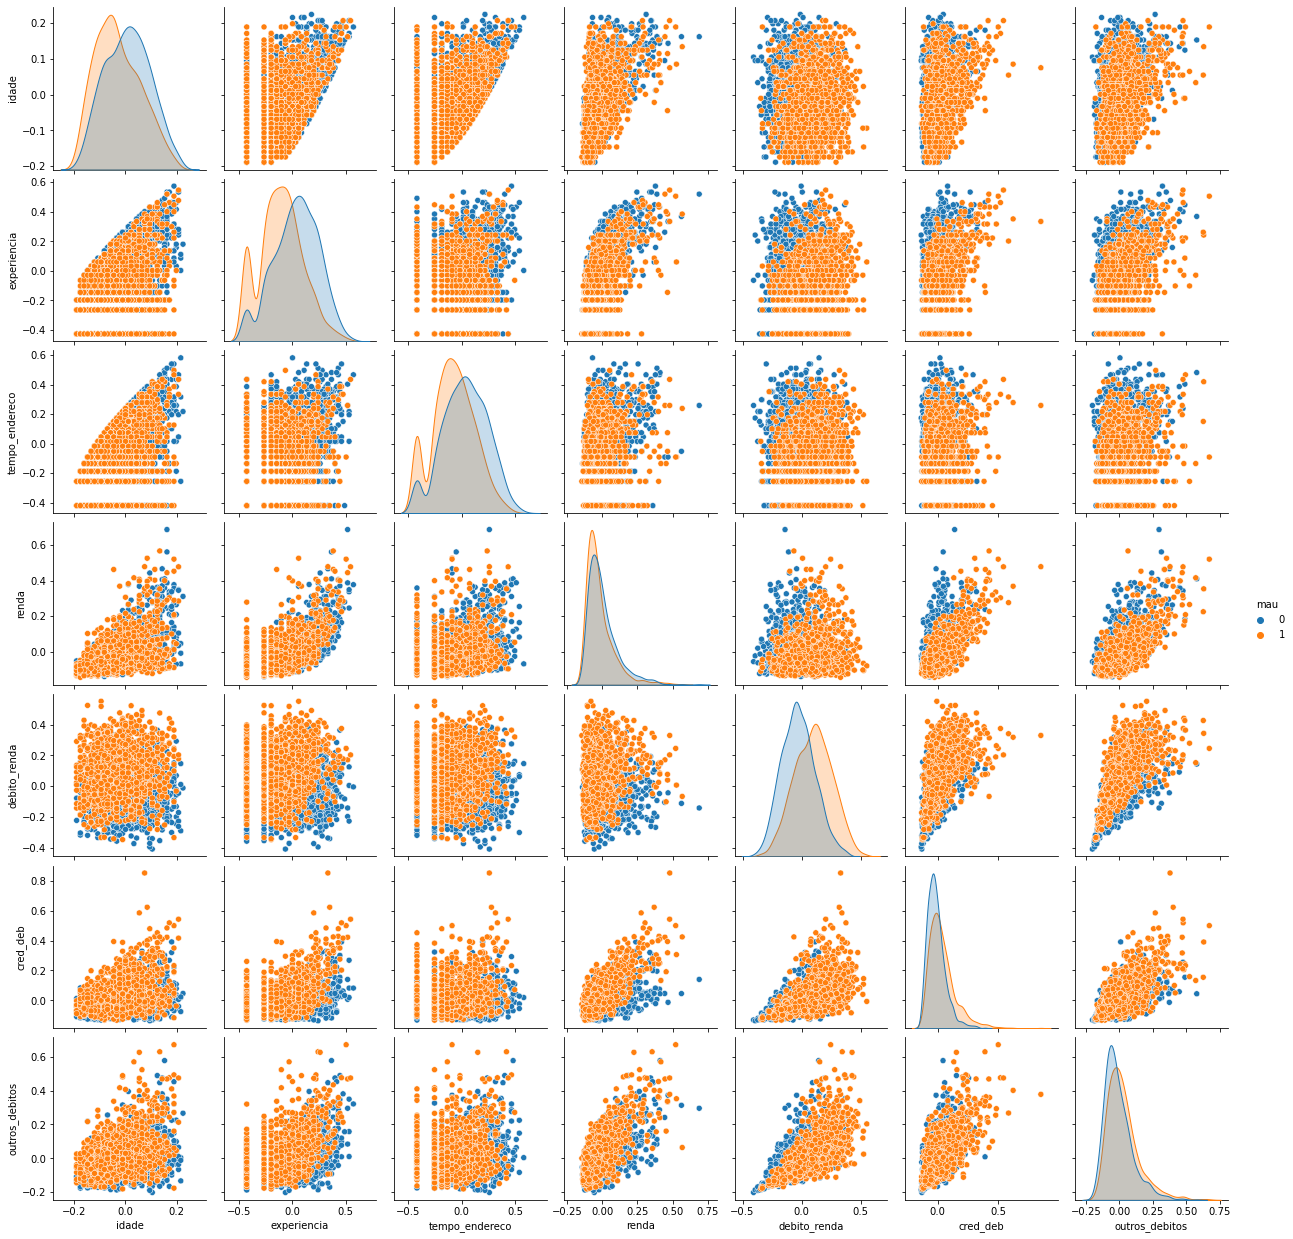

In [89]:
pairs = sns.pairplot(df_underbalanced, hue='mau')